# Deep Convolutional - Image Colorization Using LAB ColorSpace
Image colorization of grayscale to LABs green and blue component. Combined with the grayscale creates a RGB Image.

In [ ]:
%pip install -q imageio pydot tensorflow-gpu==2.9.1 keras matplotlib graphviz moviepy scikit-image keras keras-tuner matplotlib kiwisolver scikit-learn tensorflow-io


In [1]:
import os
import keras_tuner as kt
from numpy import asarray
from IPython.display import Image
import numpy as np
import matplotlib.pyplot as plt
import pathlib
import os.path
import math
import imageio.v2 as imageio
import globu
from skimage.color import lab2rgb
import PIL
import PIL.Imageu

## Import all Modules and Configure GPU

In [2]:

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import mixed_precision
import tensorflow_io as tfio

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    mixed_precisionugpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

mirrored_strategy = tf.distribute.MirroredStrategy()

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPUs will likely run quickly with dtype policy mixed_float16 as they all have compute capability of at least 7.0


2022-08-17 15:06:56.220450: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-17 15:06:56.220654: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-17 15:06:56.281623: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-17 15:06:56.281844: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-17 15:06:56.281997: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from S

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


In [3]:
tf.__version__


'2.9.1'

## Load and process data.
Will take advantage of built in tensorflow/keras for asynchronous load dataset from disk, rather force all data to be loaded in memory.

In [4]:
def load_from_directory(data_dir, train_subdir, test_subdir, image_size, batch_size, train_size=0.8):
    def configure_for_performance(ds, AUTOTUNE, shuffleSize):
        ds = ds.cache()
        if shuffleSize > 0:
            ds = ds.shuffle(buffer_size=shuffleSize, reshuffle_each_iteration=False)
        ds = ds.prefetch(buffer_size=AUTOTUNE)
        return ds

    data_train_dir = pathlib.Path(data_dir.as_posix() + "/" + train_subdir)
    image_count = len(list(data_train_dir.glob('**/*.??g')))
    print("{0}: Found {1} files".format(data_train_dir, image_count))
    train_ds = tf.keras.utils.image_dataset_from_directory(
        data_train_dir,
        interpolation='bilinear',
        color_mode='rgb',
        label_mode=None,
        follow_links=True,
        shuffle=False,
        image_size=image_size,
        batch_size=batch_size)

    #
    data_test_dir = pathlib.Path(data_dir.as_posix() + "/" + test_subdir)
    image_count = len(list(data_test_dir.glob('**/*.??g')))
    print("{0}: Found {1} files".format(data_test_dir, image_count))
    test_ds = tf.keras.utils.image_dataset_from_directory(
        data_test_dir,
        interpolation='bilinear',
        color_mode='rgb',
        label_mode=None,
        follow_links=True,
        shuffle=False,
        image_size=image_size,
        batch_size=batch_size)

    #
    AUTOTUNE = tf.data.AUTOTUNE
    normalization_layer = tf.keras.layers.Rescaling(1.0 / 255.0)

    @tf.function
    def preprocess_lab(img):
        image = tf.cast(img, tf.float32)

        lab = tfio.experimental.color.rgb_to_lab(image)
        l = lab[..., 0]

        l = tf.expand_dims(l, axis=-1)
        return tf.cast(tf.concat(l, axis=-1), tf.float32)

    @tf.function
    def preprocess_lab2(img):
        image = tf.cast(img, tf.float32)
        lab = tfio.experimental.color.rgb_to_lab(image)
        a = lab[..., 1]
        b = lab[..., 2]

        a = tf.expand_dims(a, axis=-1)
        b = tf.expand_dims(b, axis=-1)
        return tf.cast(tf.concat([a, b], axis=-1), tf.float32)

    nrBatches = image_count / batch_size

    # Translate [0,255] -> [-128, 128]
    normalized_train_ds = (train_ds.map(lambda x: preprocess_lab(normalization_layer(x))))

    # Translate [0,255] -> [-1, 1]
    normalized_test_ds = (test_ds.map(lambda x: (preprocess_lab2(normalization_layer(x)) * (1.0 / 128.0))))

    train_ds = tf.data.Dataset.zip((normalized_train_ds, normalized_test_ds))
    train_ds = train_ds.take(int(train_size * nrBatches))
    test_ds = train_ds.skip(int(train_size * nrBatches)).take(int((1.0 - train_size) * nrBatches))

    return configure_for_performance(train_ds, AUTOTUNE, 0), configure_for_performance(test_ds, AUTOTUNE, 0)


In [5]:
BATCH_SIZE = 12
IMAGE_SIZE = (256, 256)
EPOCHS = 128

data_directory_path = "data-colorize/"
data_dir = pathlib.Path(data_directory_path)

train_images, test_images = load_from_directory(data_dir, "", "", IMAGE_SIZE, BATCH_SIZE, 0.85)

print("Number of batches {0} of {1} elements".format(
    len(train_images), BATCH_SIZE))


data-colorize: Found 184438 files
Found 184438 files belonging to 1 classes.
data-colorize: Found 184438 files
Found 184438 files belonging to 1 classes.
Number of batches 13064 of 12 elements


2022-08-17 15:08:27.565604: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


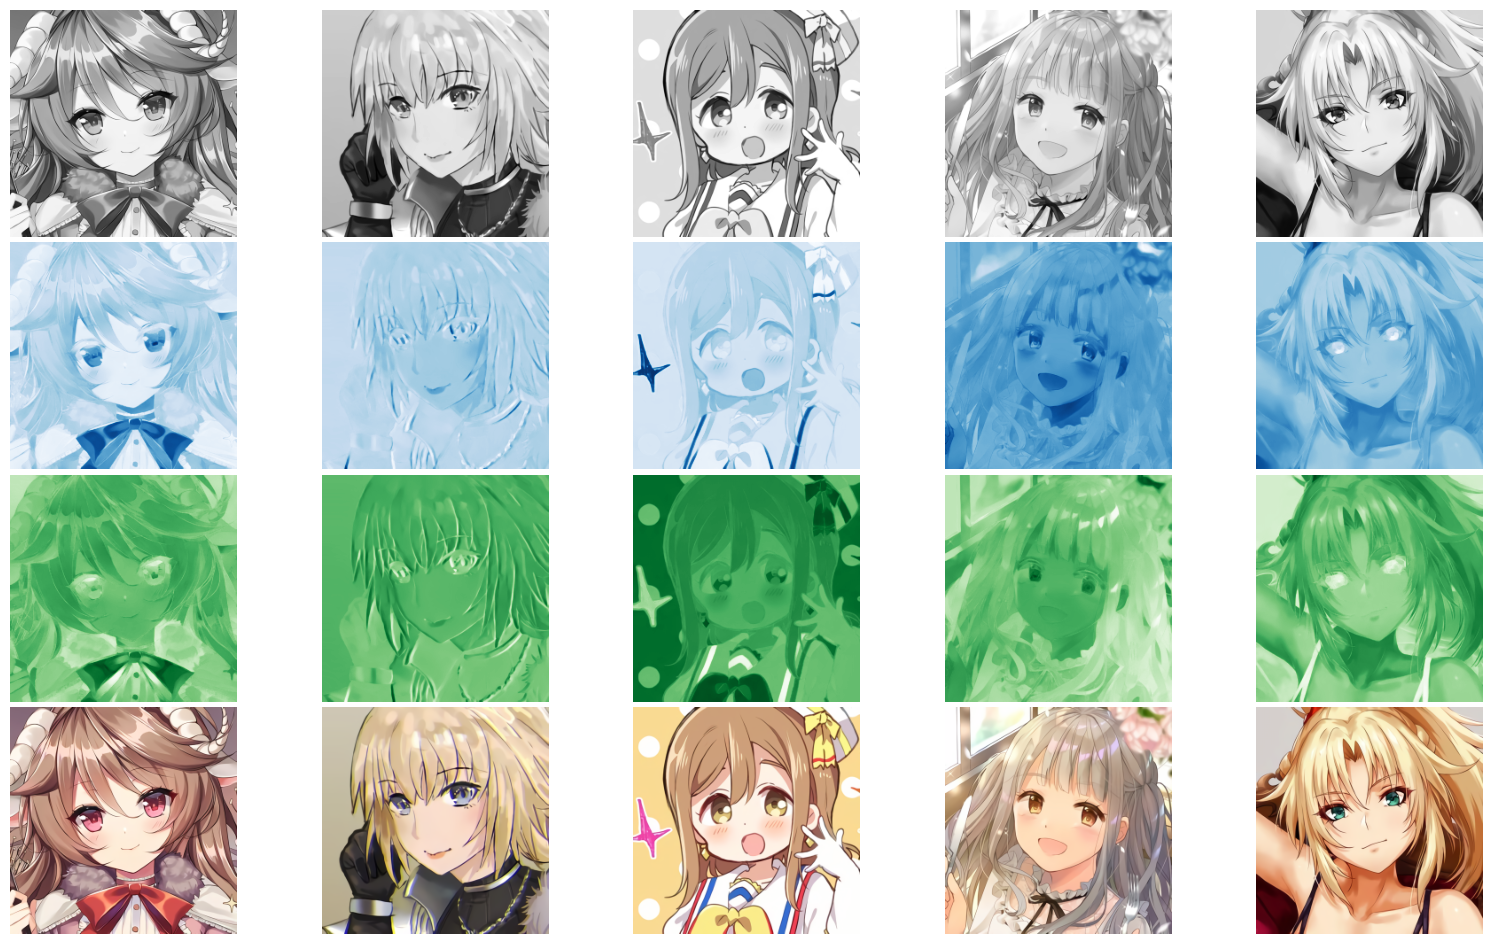

In [6]:
num_examples_to_generate = 9

nrCol = 5
plt.figure(figsize=(10 * 2, 12))
for images in train_images.take(1):
    for i in range(0, 5):

        trainImage, expectedImage = images
        # Transform pixel values from [-1,1] to [0,1]
        trainLAB = trainImage[i, :, :].numpy().astype(dtype='float32')

        ax = plt.subplot(4, nrCol, nrCol * 0 + i + 1)
        plt.imshow(trainLAB, cmap='gray')
        plt.axis("off")

        ax = plt.subplot(4, nrCol, nrCol * 1 + i + 1)
        plt.imshow(expectedImage[i, :, :, 0], cmap='Blues')
        plt.axis("off")

        ax = plt.subplot(4, nrCol, nrCol * 2 + i + 1)
        plt.imshow(expectedImage[i, :, :, 1], cmap='Greens')
        plt.axis("off")

        expectedImage = expectedImage[i, :, :, :].numpy().astype(dtype='float32') * 128
        RGBImage = np.zeros((IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
        RGBImage[:, :, 0] = trainLAB[:, :, 0]
        RGBImage[:, :, 1:] = expectedImage

        rgbExpected = lab2rgb(RGBImage)

        ax = plt.subplot(4, nrCol, nrCol * 3 + i + 1)
        plt.imshow(rgbExpected)
        plt.axis("off")
plt.subplots_adjust(wspace=0.025, hspace=0.025)
plt.show()


## Create Model

In [7]:
def create_model(hp, input_shape):
    model = tf.keras.Sequential()

    kernel_init = hp.Choice('kernel_initializer', ['uniform', 'lecun_uniform', 'normal', 'zero',
                                                   'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform'])

    model.add(layers.Input(input_shape))

    number_layer_offset = hp.Int('number_layers', min_value=2, max_value=6, step=1)
    max_layers = 3

    n2 = math.log2(float(IMAGE_SIZE[0]))
    num_layers = max(int(n2) - number_layer_offset, 0)
    num_layers = max(1, min(num_layers, max_layers))

    hp_kernel_filter_size_l0 = hp.Int('kernel_filter_downscale', min_value=4, max_value=8, step=1)

    for i in range(0, num_layers + 1):
        filter_size = 2 ** (i + hp_kernel_filter_size_l0)

        #model.add(layers.Conv2D(filter_size, (3, 3), activation='relu', padding='same', kernel_initializer=kernel_init))

        model.add(layers.Conv2D(filters=filter_size, kernel_size=(3, 3), padding='same', kernel_initializer=kernel_init))
        model.add(layers.ReLU(dtype='float32'))
        model.add(layers.Conv2D(filter_size, (3, 3), padding='same', strides=2))
        model.add(layers.ReLU(dtype='float32'))
        #model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    # model.add(layers.Flatten())
    hp_kernel_filter_size_latent = hp.Int('kernel_filter_latent', min_value=6, max_value=9, step=1)
    model.add(layers.Conv2D(2 ** hp_kernel_filter_size_latent, (3, 3), padding='same', kernel_initializer=kernel_init))
    model.add(layers.ReLU(dtype='float32'))
    model.add(layers.Conv2D(2 ** (hp_kernel_filter_size_latent - 1), (3, 3), padding='same', kernel_initializer=kernel_init))
    model.add(layers.ReLU(dtype='float32'))

    hp_kernel_filter_size_l1 = hp.Int('kernel_filter_upscale', min_value=5, max_value=9, step=1)

    #upscale_number_layer_offset = hp.Int('upscale_number_layer_offset', min_value=4, max_value=6, step=1)

    for i in range(0, num_layers + 1):
        filter_size = 2 ** (hp_kernel_filter_size_l1 - i)

        #model.add(layers.Conv2D(filter_size, (2, 2), strides=(2, 2), activation='relu', padding='same'))
        #model.add(layers.Conv2D(filter_size, (3, 3), activation='relu', padding='same', kernel_initializer=kernel_init))
        model.add(layers.UpSampling2D(size=(2, 2)))
        model.add(layers.Conv2D(filter_size, (3, 3), padding='same', kernel_initializer=kernel_init))
        model.add(layers.ReLU(dtype='float32'))

    model.add(layers.Conv2D(2, (3, 3), padding='same', kernel_initializer=kernel_init))
    model.add(layers.Activation(activation='tanh', dtype='float32'))

    hp_optimizer = hp.Choice('optimizer', ['sgd', 'adam', 'rmsprop'])

    model.compile(optimizer=hp_optimizer,
                  loss='mse',
                  metrics=['accuracy'])

    return model


## Hyperparameter

In [ ]:

image_shape = (IMAGE_SIZE[0], IMAGE_SIZE[1], 1)

def model_builder(hp):
    model = create_model(hp, image_shape)
    return model


tuner = kt.Hyperband(model_builder,
                     objective='accuracy',
                     max_epochs=16,
                     factor=5,
                     directory='cache',
                     project_name=str.format('Colorizing - LAB - {0}', "Anime"))

stop_early = tf.keras.callbacks.EarlyStopping(
    monitor='loss', patience=5)
tuner.search(train_images.take(1000), validation_data=test_images, epochs=EPOCHS, batch_size=BATCH_SIZE,
             callbacks=[stop_early], verbose=1)

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_models = tuner.get_best_models(4)

model = tuner.hypermodel.build(best_hps)
model.summary()


## Train the Model

In [9]:
def showResult(model, batchImage, maxNumImages=6):
    output = model.predict(batchImage)
    output = output * 128
    nrElements = min(len(output), maxNumImages)

    fig = plt.figure(figsize=(maxNumImages * 2, 4 * 2))
    for image in batchImage:
        for i in range(nrElements):
            trainImage, expectedImage = image

            canvas = np.zeros((IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
            canvas[:, :, 0] = trainImage[i][:, :, 0]
            canvas[:, :, 1:] = expectedImage[i][:, :, :] * 128

            ax = plt.subplot(4, maxNumImages, i + 1)
            plt.imshow((asarray(lab2rgb(canvas)).astype(dtype='float32')))
            plt.axis("off")

            ax = plt.subplot(4, maxNumImages, maxNumImages * 1 + i + 1)
            plt.imshow(output[i, :, :, 0], cmap='Blues')
            plt.axis("off")

            ax = plt.subplot(4, maxNumImages, maxNumImages * 2 + i + 1)
            plt.imshow(output[i, :, :, 1], cmap='Greens')
            plt.axis("off")

            canvas = np.zeros((IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
            canvas[:, :, 0] = trainImage[i][:, :, 0]
            canvas[:, :, 1:] = output[i][:, :, :]

            ax = plt.subplot(4, maxNumImages, maxNumImages * 3 + 1 + i)
            plt.imshow(asarray(lab2rgb(canvas)).astype(dtype='float32'))
            plt.axis("off")

    fig.subplots_adjust(wspace=0.05, hspace=0.05)
    plt.close()
    return fig


class save_images(tf.keras.callbacks.Callback):

    def __init__(self, trainData, **kwargs):
        super(tf.keras.callbacks.Callback, self).__init__(**kwargs)
        self.trainData = trainData
        self.trainSet = self.trainData.take(1)

    def on_epoch_end(self, epoch, logs=None):
        fig = showResult(self.model, self.trainSet)
        fig.savefig("animeColorLAB{0}.png".format(epoch))
        fig = showResult(self.model, self.trainSet, 12)
        fig.savefig("animeColorLABBig{0}.png".format(epoch))


In [10]:

checkpoint_path = "checkpoints/training_anime_coloring_lab/cp.ckpt"

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=0)

checkpoint = tf.train.Checkpoint(model=model)
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_path)).expect_partial()


# The model weights (that are considered the best) are loaded into the model.
if os.path.exists(checkpoint_path):
    model.load_weights(checkpoint_path)

model_history = model.fit(train_images,
                          epochs=EPOCHS,
                          batch_size=1,
                          validation_data=test_images,
                          verbose=1, callbacks=[cp_callback, save_images(train_images)])

model.save_weights(checkpoint_path)


Epoch 1/128


2022-08-17 15:08:38.627845: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8500
2022-08-17 15:08:39.122572: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


  239/13064 [..............................] - ETA: 33:40 - loss: 0.0185 - accuracy: 0.5880

In [ ]:
model.save("dc-anime-colorization-lab.h5")


: 

# Result

In [ ]:
plt.imshow(PIL.Image.open("animeColorLABBig{0}.png".format(EPOCHS - 1)))
plt.axis("off")
plt.show()


: 

In [ ]:
anim_file = 'anime-colorizing-lab.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('animeColorLABBig*.png')
    filenames = sorted(filenames)
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

Image(url=anim_file)


: 

In [ ]:
def plotCostHistory(history, loss_label="", val_label="", title="", x_label="", y_label=""):
    fig = plt.figure()
    for k, v in history.items():
        plt.plot(v, label=k)
    plt.title(label=title)
    plt.ylabel(ylabel=y_label)
    plt.xlabel(xlabel=x_label)
    plt.legend(loc="upper left")
    fig.show()
    fig.savefig(title + ".png")


: 

In [ ]:
plotCostHistory(model_history.history, title=str.format(
    "CNN {0} Performance History", "Anime Colorizing - LAB ColorSpace"))

tf.keras.utils.plot_model(
    model, to_file=str.format('{0}.png', "Anime Colorizing - LAB ColorSpace"), show_shapes=True, show_dtype=True,
    show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96,
    layer_range=None
)


: 